## QBUS6840 - Assignment

## 1. Load and Explore Data

### 1.1 Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt
import pmdarima as pm

In [2]:
# Load classes from our utilitise
from QBUS_utilities import SimpleModel
# Load scoring functions from our utilities
from QBUS_utilities import RMSE, MAPE

In [4]:
# load data - there are no missing values
df_raw = pd.read_csv('data/UnderemploymentRate_InSample.csv')

display(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  475 non-null    object 
 1   Underemployment Rate  475 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


None

,Date,Underemployment Rate
0,1/06/1978,4.270054
1,1/07/1978,3.933794
2,1/08/1978,4.045333
3,1/09/1978,3.999336
4,1/10/1978,3.722322


### 1.2 Plotting and Trend/Seasonality

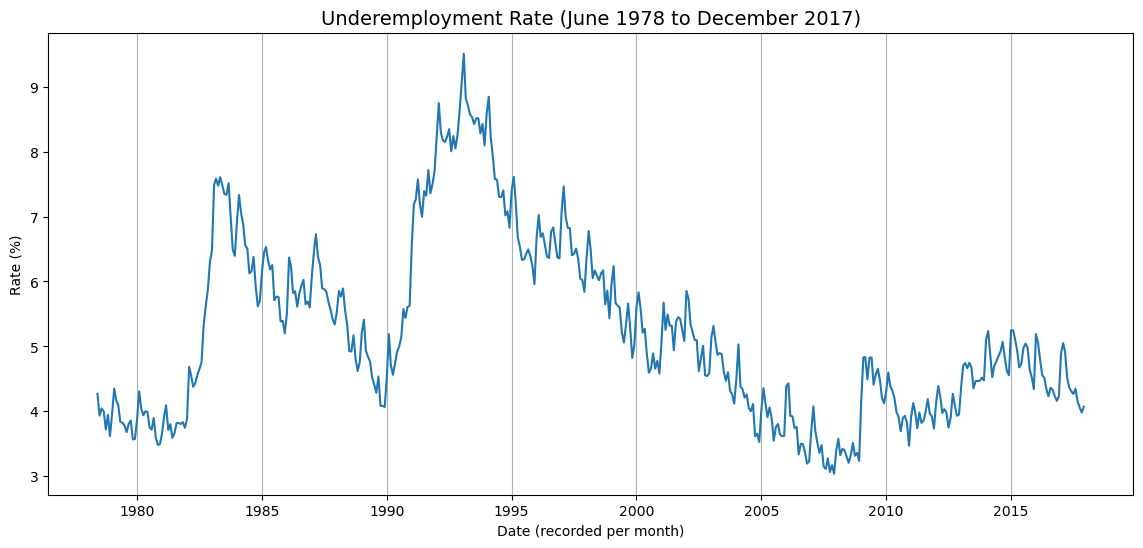

In [91]:
# Convert Date to datetime and set as index
df_ts = df_raw.copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%d/%m/%Y") # Fix format to day-month-year
df_ts = df_ts.set_index('Date')
df_ts.index.freq = 'MS'

# Plot the training dataset
plt.figure(figsize=(14,6))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (recorded per month)', fontsize=10)
plt.ylabel('Rate (%)', fontsize=10)

plt.gca().xaxis.grid(True)
plt.plot(df_ts.index, df_ts['Underemployment Rate'])

plt.show()

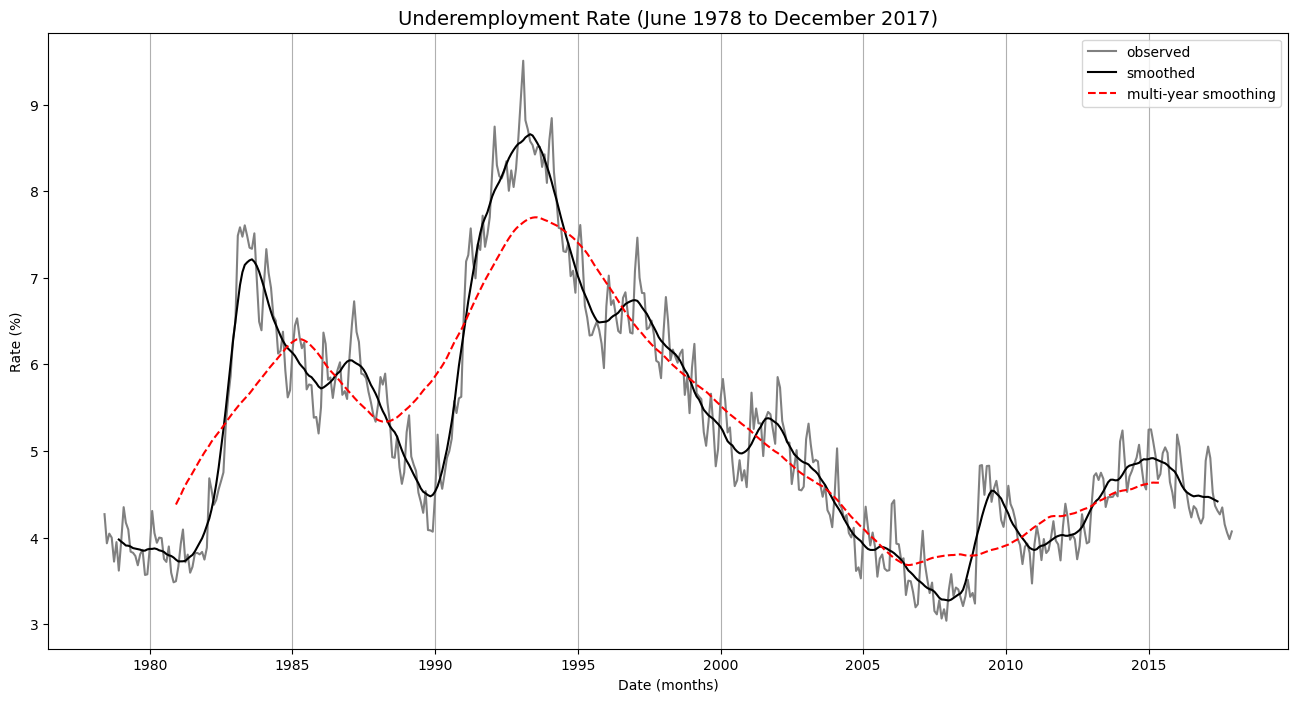

In [6]:
# Can observe an annaul trend, with a peak in January and trough in December
# Additionally, there may be an even greater multi-year trend

# Let's smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)
df_multi_smoothing = df_ts.rolling(60, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(16,8))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (months)', fontsize=10)
plt.ylabel('Rate (%)', fontsize=10)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='observed', color='gray')
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='smoothed', color='black')
plt.plot(df_multi_smoothing.index, df_multi_smoothing['Underemployment Rate'],
         label='multi-year smoothing', color='red', linestyle='dashed')

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

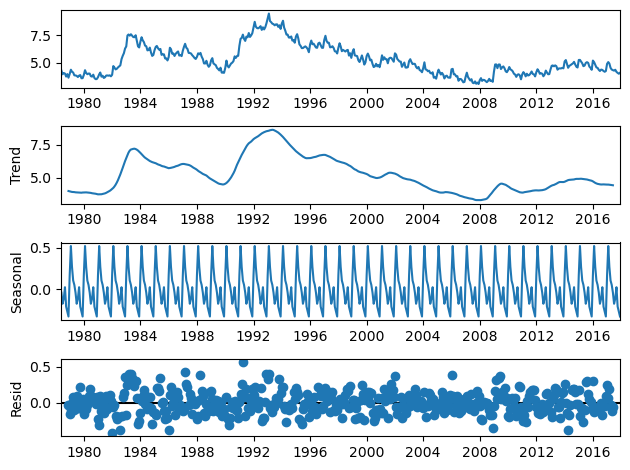

In [7]:
# We can observe more analytically using the statsmodels package for decomposition
## When we allow an additive model, the formula naturally finds an annual seasonal pattern
## If we set the decomposition to multiplicative and/or fix a period > 12 months, we get uneven residuals

decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                   model = 'additive',
                                                   period = None,
                                                   #model = 'multiplicative',
                                                   #period = 60,
                                                  )

decomposition.plot()

plt.show()

### 1.3 Statistical Summary

### 1.4 Transformations

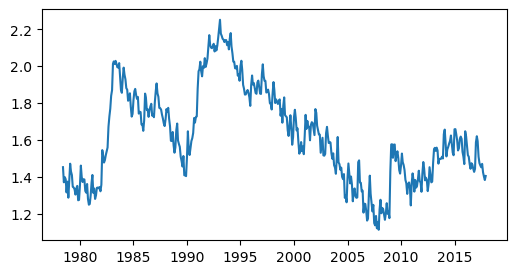

In [30]:
# Transformation:
## (a) log scale
## (b) Differencing
plt.figure(figsize=(6,3))
df_log = np.log(df_ts)
plt.plot(df_log)
plt.show()

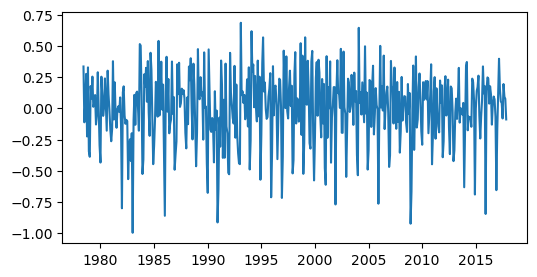

In [31]:
plt.figure(figsize=(6,3))
df_diff = df_ts - df_ts.shift(-1)
plt.plot(df_diff)
plt.show()

## 2. Detailed Exploration for ARIMA

**Goal:** Exploratory Analysis of the stationarity, auto-regressive features and errors to inform candidates for Seasonal ARIMA modelling

**Sections**
- 2.1 Stationarity & Differencing
- 2.2 Auto-Correlation
- 2.3 Partial Auto-Correlation

We can apply these tests, as well as AIC/BIC to determine best candidates for SARIMA.

### 2.1 Stationarity

In [ ]:
## TO DO: Invertability Check!

The Augmented Dickey-Fuller test for the original time series is: ADF=-2.0209 | P-Value=0.2775



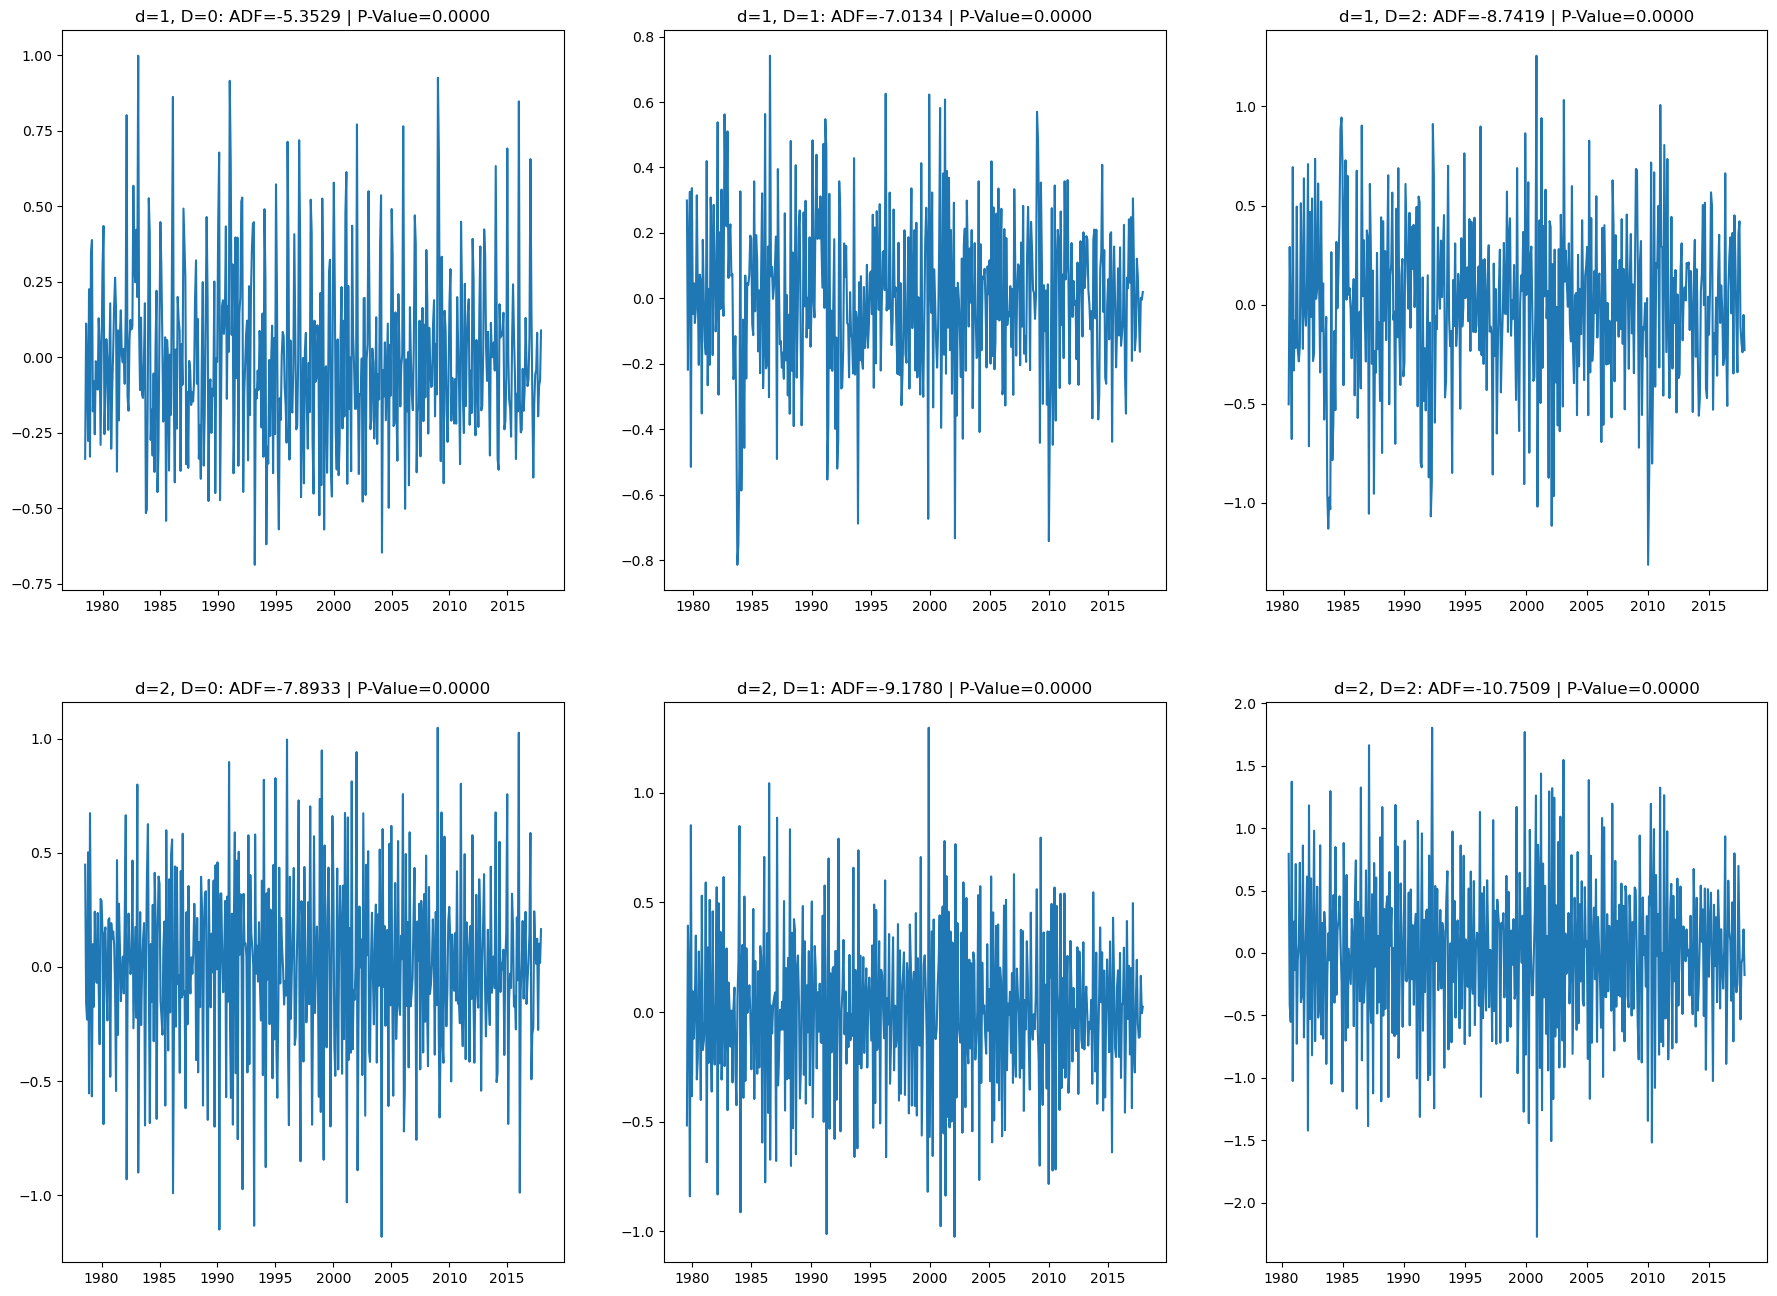

In [32]:
# From EDA, we observe that the time series is not stationary (i.e. the mean, variaance and co-variance are not a function of time) and that there is annual seasonality
## This includes weakly stationary where the function doesn't change over time - we can see changing trends and different jump sizes

# We can apply the Augmented Dickey-Fuller test to evaluate stationarity, and then compare these to ACF/PACF plots below
adf_test = sm.tsa.stattools.adfuller(df_ts)
print(f'The Augmented Dickey-Fuller test for the original time series is: ADF={adf_test[0]:.4f} | P-Value={adf_test[1]:.4f}')
print()

# Plot the differencing
plt.figure(figsize=(22,16))
nrows, ncols = 2, 3

# Create a loop for differencing order [d, D]
for i, diff_plot in enumerate([[1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    plt.subplot(nrows, ncols, i+1)
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)
        
    adf_test = sm.tsa.stattools.adfuller(df_diff.dropna())
    plt.title(f'd={diff_plot[0]}, D={diff_plot[1]}: ADF={adf_test[0]:.4f} | P-Value={adf_test[1]:.4f}')
    plt.plot(df_diff)
    
plt.show()

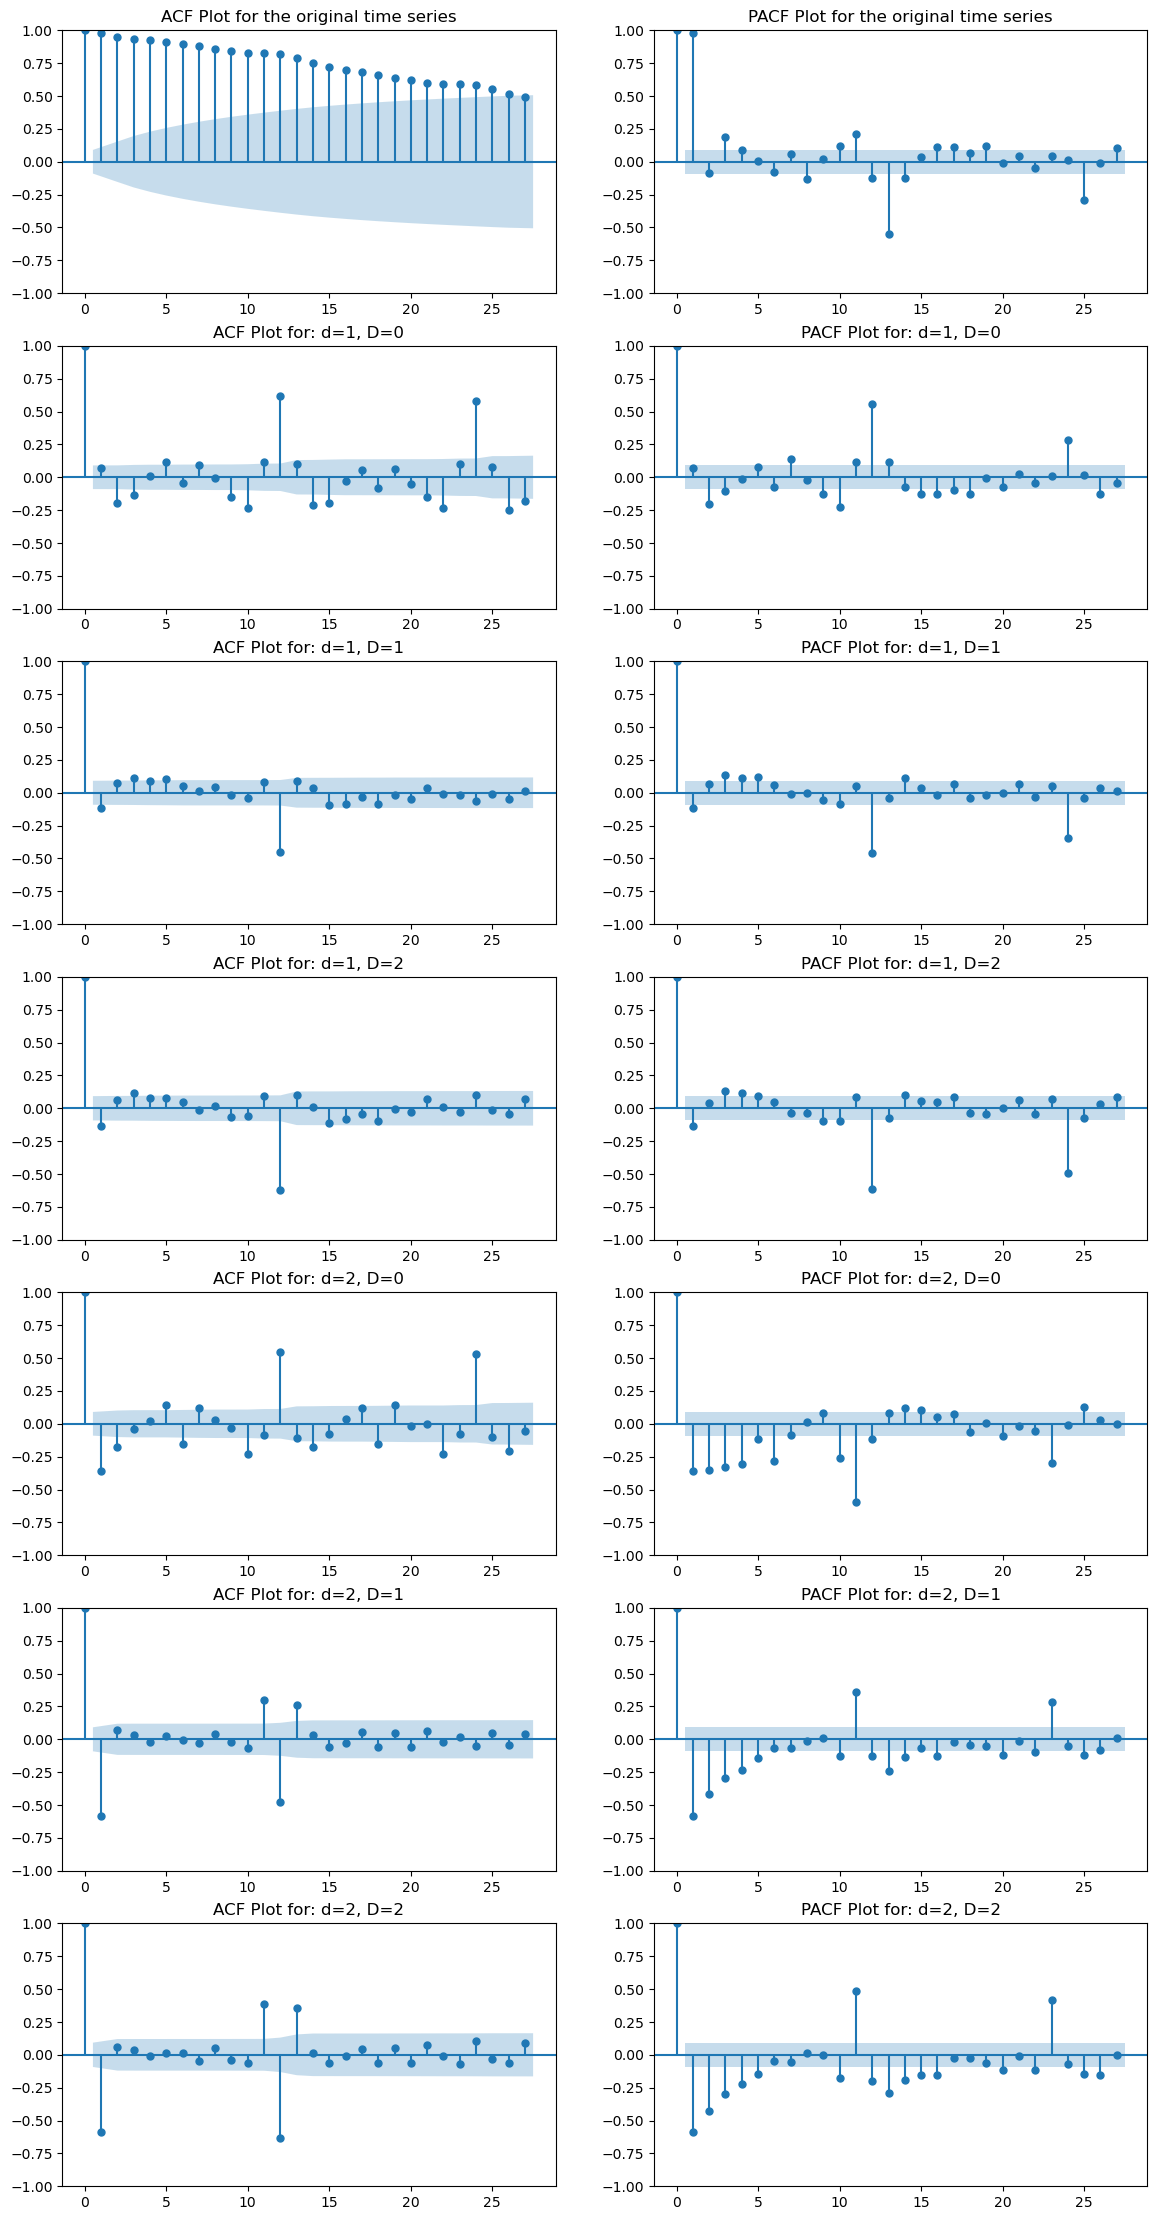

In [76]:
# Next we look at the ACF and PACF plot to determine (a) whether the data is stationary and (b) candidates for Auto-Regression (AR) and Moving Average (MA)
plt.figure(figsize=(14,28))
nrows, ncols = 7, 2

sm.graphics.tsaplots.plot_acf(df_ts.dropna(),
                              ax=plt.subplot(nrows, ncols, 1),
                              title='ACF Plot for the original time series'
                             )
sm.graphics.tsaplots.plot_pacf(df_ts.dropna(), method='ywm',
                               ax=plt.subplot(nrows, ncols, 2),
                               title='PACF Plot for the original time series'
                              )

# Create a loop for differencing order [d, D]
for i, diff_plot in enumerate([[1, 0],
                               [1, 1],
                               [1, 2],
                               [2, 0],
                               [2, 1],
                               [2, 2]
                              ]):
    df_diff = df_ts.copy()
    
    for base_diff in range(diff_plot[0]):
        df_diff -= df_diff.shift(1)
        
    for seas_diff in range(diff_plot[1]):
        df_diff -= df_diff.shift(12)

    sm.graphics.tsaplots.plot_acf(df_diff.dropna(),
                                  ax=plt.subplot(7, 2, 2*i+3),
                                  title=f'ACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                 )
    sm.graphics.tsaplots.plot_pacf(df_diff.dropna(), method='ywm', lags=40 # ADDED
                                   ax=plt.subplot(7, 2, 2*i+4),
                                   title=f'PACF Plot for: d={diff_plot[0]}, D={diff_plot[1]}'
                                  )
plt.show()

In [ ]:
## Differencing using AIC
#import statsmodels.tsa.stattools as st 

order = st.arma_order_select_ic(sales_diff,max_ar=5,max_ma=5,ic=['aic'])
print(order.aic_min_order)

In [102]:
# For ACF: Drops after 1, 3, or 5 and any seasonal differencing stops after t=12
## Possibilities include:
##    MA(q) = 1, 2, 3, 5
##    MA(Q) = 1, 2

# For PACF: Reduces to around 5 (maybe 7) and seasonal differencing continues at t=24
## Posibilities include:
##    AR(p) = 1, 3, 4, 5, 7
##    AR(P) = 1, 2, 3

# Set the hyper-parameters to search over the space and record the result for our validation datasets
## ARIMA-Seasonal(p,d,q)(P,D,Q)
p = [1, 3, 4, 5, 7]
d = [1, 2]
q = [1, 2, 3, 5]
P = [1, 2, 3]
D = [1, 2]
Q = [1, 2]

## 2. Data Preparation

### 2.1 Create a Training-Validation Split (expanding window)

In [67]:
# (a) Forecast window of 24, expanding by 12 months each time
# For cross-validation, create an expanding window to forecast on validation data
# Aim to create 5 validation splits

(475, 1)

In [93]:
# (b) Alternative: 24 months window, but still only expanding by 12 months
## Calculating rolling: x * 12 + window
# For cross-validation, create an expanding window to forecast on validation data
# Aim to create 5 validation splits
splits = 5
train_folds = dict()
val_folds = dict()
forecast_window = 24 # forecast length in months

for n in range(splits):
    train_folds[n] = df_ts[:-(splits-n)*12-forecast_window]
    val_folds[n] = df_ts[-(splits-n)*12-forecast_window:]
    val_folds[n] = val_folds[n][:forecast_window] # Limit the test size to the forecast window
    
    print(f'Split {n}: Train - {train_folds[n].shape} | Validation - {val_folds[n].shape}')

Split 0: Train - (391, 1) | Validation - (24, 1)
Split 1: Train - (403, 1) | Validation - (24, 1)
Split 2: Train - (415, 1) | Validation - (24, 1)
Split 3: Train - (427, 1) | Validation - (24, 1)
Split 4: Train - (439, 1) | Validation - (24, 1)


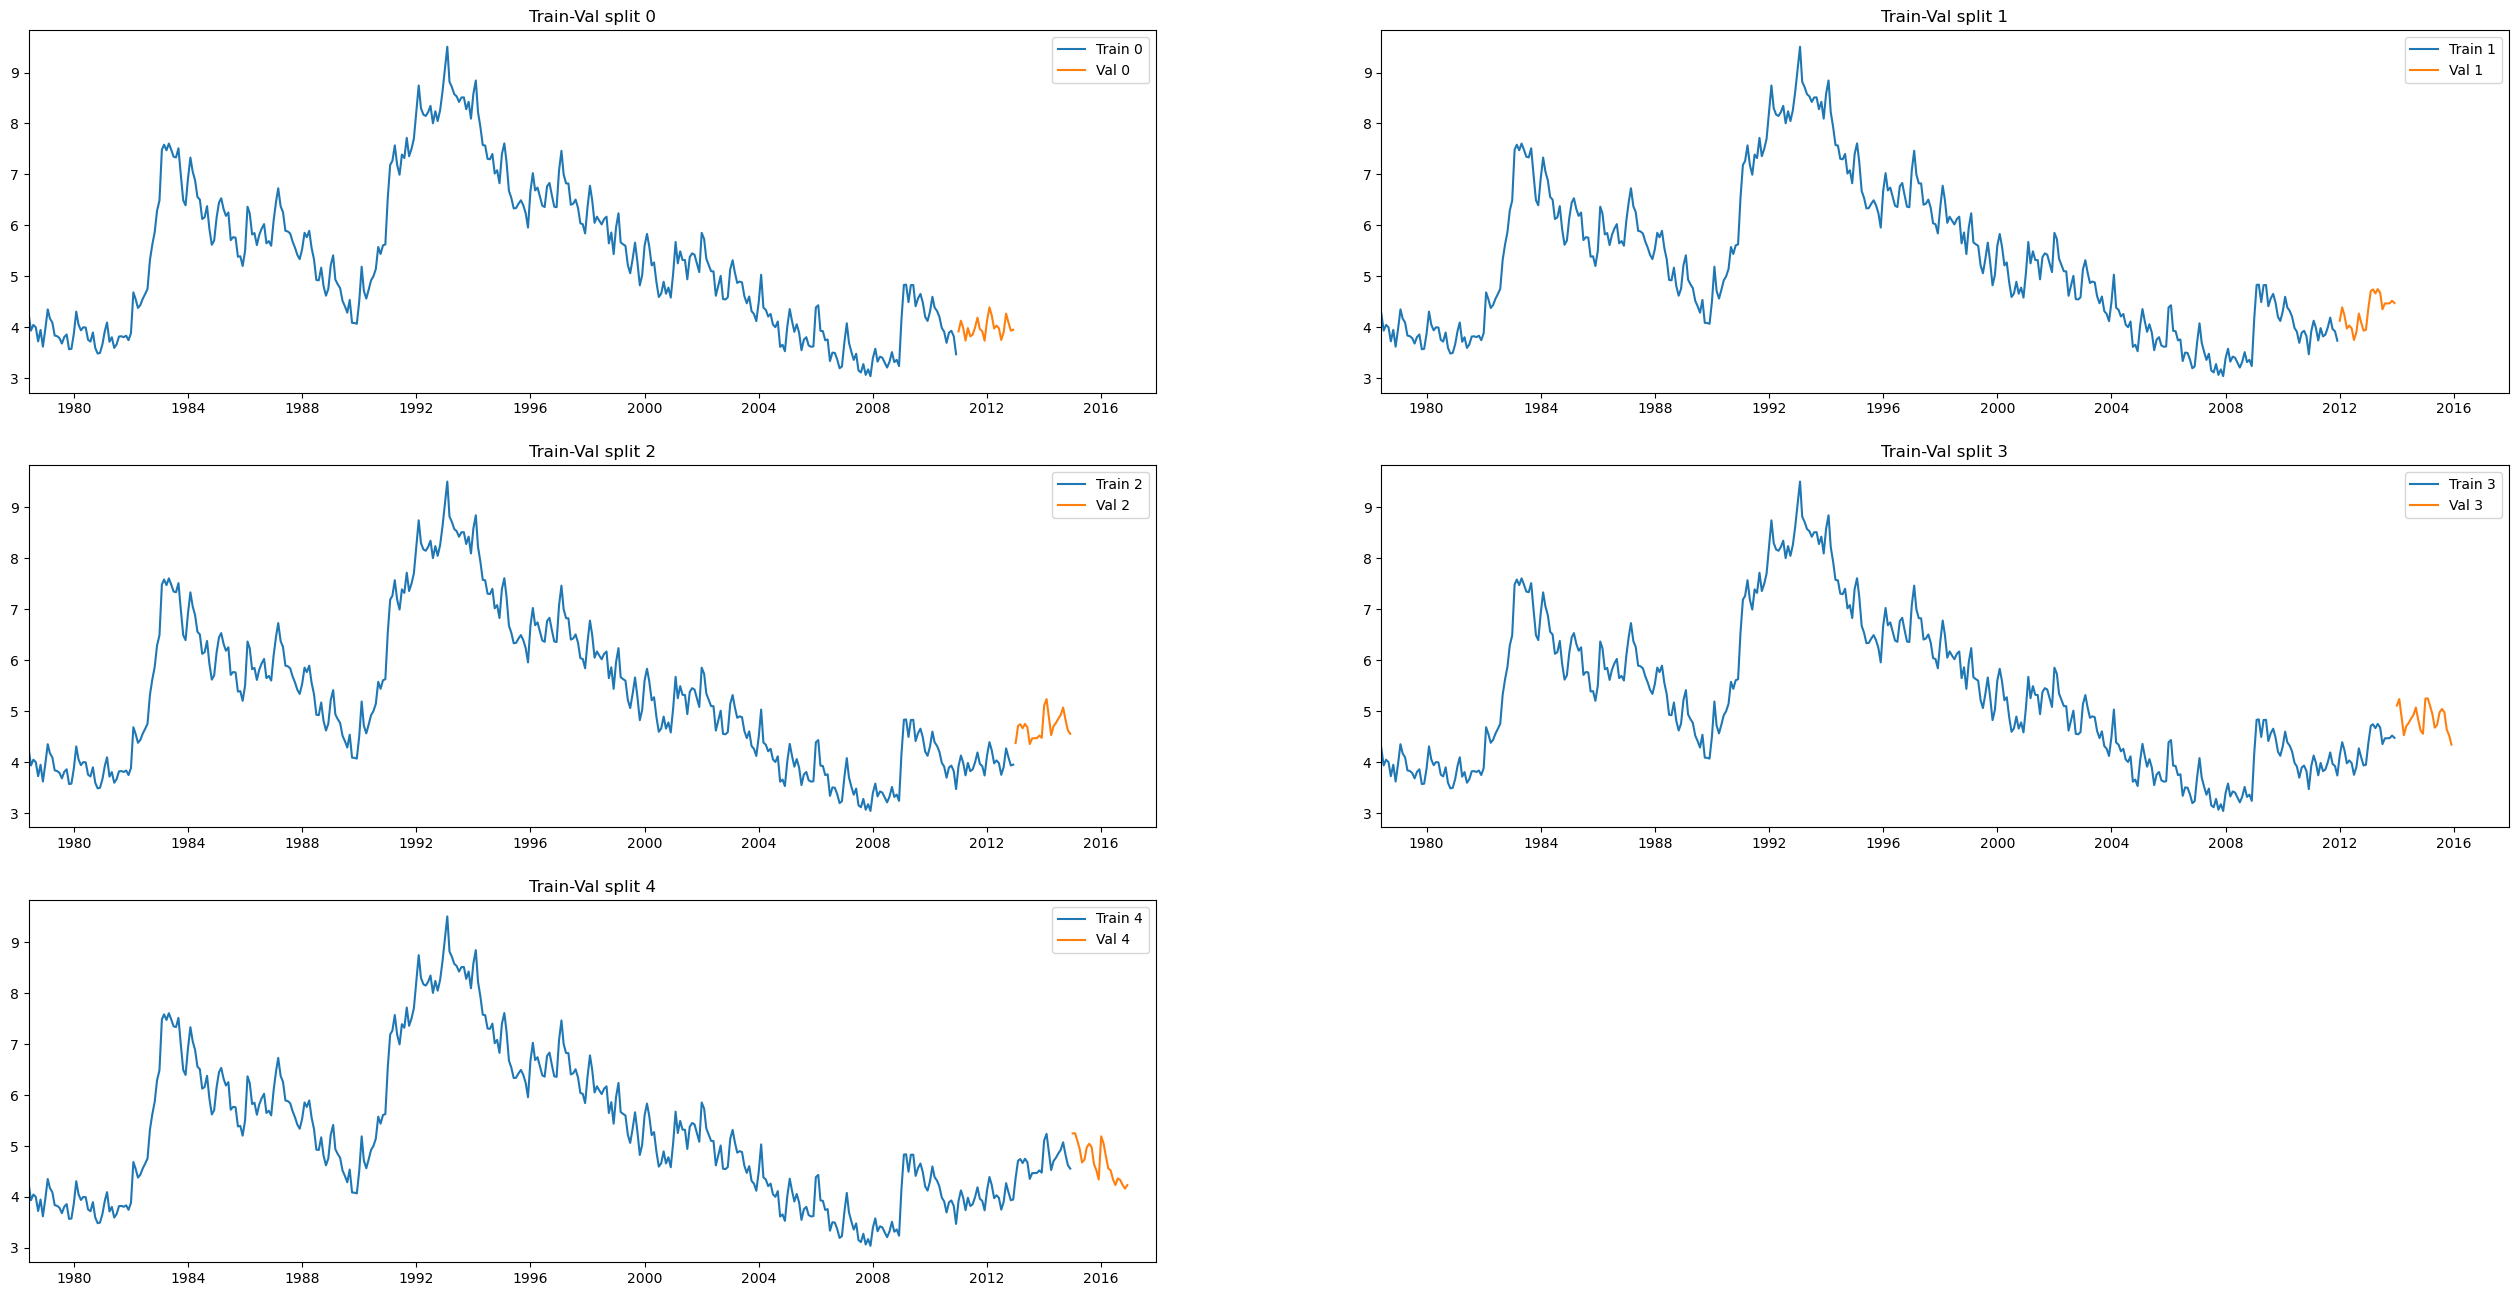

In [94]:
# Plot the train-val splits
plt.figure(figsize=(32,16))
start = min(df_ts.index)
end = xmax=max(df_ts.index)

for i in range(splits):
    ax = plt.subplot(3, 2, i + 1)
    
    ax.set_title(f'Train-Val split {i}')
    ax.set_xlim(start, end)
    ax.plot(train_folds[i], label=f'Train {i}')
    ax.plot(val_folds[i], label=f'Val {i}')
    ax.legend()
    

plt.show()

## 3. Modelling

In [129]:
df_train = train_folds[4]
df_val = val_folds[4]

df_train.shape, df_val.shape

((439, 1), (24, 1))

In [138]:
# Using auto-ARIMA
# Fit your model
model = pm.auto_arima(df_train, seasonal=True, m=12, suppress_warnings=True)

# make your forecasts
forecasts = model.predict(df_val.shape[0])  # predict N steps into the future

In [86]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [89]:
df_val.index[-1]

Timestamp('2016-12-01 00:00:00')

In [134]:
# Define a SARIMAX model
model_2 = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                          order = (2,1,2),                 # Non-seasonal component
                                          seasonal_order = (1,1,0,12),     # Seasonal component
                                          enforce_stationarity = False,
                                          enforce_invertibility = False,
                                          freq='MS'
                                         ).fit()


forecasts_2 = model_2.predict(df_val.index[0], df_val.index[-1])  # predict N steps into the future

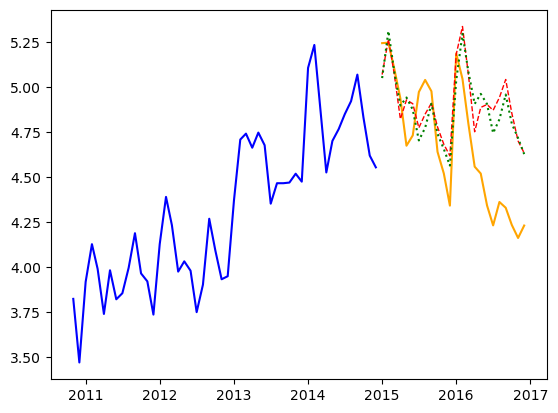

In [139]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.plot(df_train.index[-50:], df_train[-50:], c='blue')
plt.plot(df_val.index, df_val, c='orange')
plt.plot(df_val.index, forecasts_2, c='red', linestyle='dashed', linewidth=1)
plt.plot(df_val.index, forecasts, c='green', linestyle='dotted')

plt.show()

In [112]:
[p[0], q[0]]

[1, 1]

In [115]:
# Conduct a Grid-Search to find the optimal hyper-params for SARIMA based on our candidates

## NOTE: Grid Search has ~480 parameters, creating a shorter list here for exploration (can run final over time later)

p = [1, 2, 5]
d = [1, 2]
q = [2, 3]
P = [0, 1, 3]
D = [1, 2]
Q = [0, 2]

## REMOVE WHEN USING TRUE PARAMETERS
print('Starting Gridsearch...')
print('Number of params = ', len(p)*len(d)*len(q)*len(P)*len(D)*len(Q))

# Define a SARIMAX model testing all values
best_params = [0, 0, 0, 0, 0, 0]
best_rmse = 1_000
for P_trial in P:
    for Q_trial in Q:
        for D_trial in D:
            for p_trial in p:
                for q_trial in q:
                    for d_trial in d:
                        model = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                                  order = (p_trial, d_trial, q_trial),              # Non-seasonal component
                                                                  seasonal_order = (P_trial, D_trial, Q_trial, 12), # Seasonal component
                                                                  enforce_stationarity = False,
                                                                  enforce_invertibility = False,
                                                                  freq = 'MS'
                                                                 ).fit()


                        forecasts = model.predict(df_val.shape[0])                                                  # predict N steps into the future
                        error = RMSE(df_val.values, forecasts.values)
                        print(f'Fit ({p_trial, d_trial, q_trial})({P_trial, D_trial, Q_trial}): RMSE = {error:.4f}')
                        
                        if error < best_rmse:
                            best_rmse = error
                            best_params = [[p_trial,
                                            d_trial,
                                            q_trial
                                           ],
                                           [P_trial,
                                            D_trial,
                                            Q_trial,
                                            12
                                           ]]
                            print('New Best Score!')

print(f'Complete. Best parameters are: {best_params} with error {best_rmse}')

Starting Gridsearch...
Number of params =  144
Fit ((1, 1, 2))((0, 1, 0)): RMSE = 1.6419
New Best Score!
Fit ((1, 2, 2))((0, 1, 0)): RMSE = 1.6373
New Best Score!
Fit ((1, 1, 3))((0, 1, 0)): RMSE = 1.6415
Fit ((1, 2, 3))((0, 1, 0)): RMSE = 1.6375
Fit ((2, 1, 2))((0, 1, 0)): RMSE = 1.6421
Fit ((2, 2, 2))((0, 1, 0)): RMSE = 1.6378
Fit ((2, 1, 3))((0, 1, 0)): RMSE = 1.6411
Fit ((2, 2, 3))((0, 1, 0)): RMSE = 1.6377


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((0, 1, 0)): RMSE = 1.6407
Fit ((5, 2, 2))((0, 1, 0)): RMSE = 1.6438


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((0, 1, 0)): RMSE = 1.6397


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((0, 1, 0)): RMSE = 1.6373
New Best Score!
Fit ((1, 1, 2))((0, 2, 0)): RMSE = 1.6795
Fit ((1, 2, 2))((0, 2, 0)): RMSE = 1.6633
Fit ((1, 1, 3))((0, 2, 0)): RMSE = 1.6778
Fit ((1, 2, 3))((0, 2, 0)): RMSE = 1.6635
Fit ((2, 1, 2))((0, 2, 0)): RMSE = 1.6700
Fit ((2, 2, 2))((0, 2, 0)): RMSE = 1.6637
Fit ((2, 1, 3))((0, 2, 0)): RMSE = 1.6701
Fit ((2, 2, 3))((0, 2, 0)): RMSE = 1.6609
Fit ((5, 1, 2))((0, 2, 0)): RMSE = 1.6764
Fit ((5, 2, 2))((0, 2, 0)): RMSE = 1.6795
Fit ((5, 1, 3))((0, 2, 0)): RMSE = 1.6655


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((0, 2, 0)): RMSE = 1.6719
Fit ((1, 1, 2))((0, 1, 2)): RMSE = 1.6317
New Best Score!
Fit ((1, 2, 2))((0, 1, 2)): RMSE = 1.6360
Fit ((1, 1, 3))((0, 1, 2)): RMSE = 1.6316
New Best Score!
Fit ((1, 2, 3))((0, 1, 2)): RMSE = 1.6360
Fit ((2, 1, 2))((0, 1, 2)): RMSE = 1.6319
Fit ((2, 2, 2))((0, 1, 2)): RMSE = 1.6360


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((0, 1, 2)): RMSE = 1.6312
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((0, 1, 2)): RMSE = 1.6369


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((0, 1, 2)): RMSE = 1.6311
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((0, 1, 2)): RMSE = 1.6355


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((0, 1, 2)): RMSE = 1.6301
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((0, 1, 2)): RMSE = 1.6355
Fit ((1, 1, 2))((0, 2, 2)): RMSE = 1.6434
Fit ((1, 2, 2))((0, 2, 2)): RMSE = 1.6409
Fit ((1, 1, 3))((0, 2, 2)): RMSE = 1.6442
Fit ((1, 2, 3))((0, 2, 2)): RMSE = 1.6407
Fit ((2, 1, 2))((0, 2, 2)): RMSE = 1.6450
Fit ((2, 2, 2))((0, 2, 2)): RMSE = 1.6403


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((0, 2, 2)): RMSE = 1.6480


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((0, 2, 2)): RMSE = 1.6405
Fit ((5, 1, 2))((0, 2, 2)): RMSE = 1.6441


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((0, 2, 2)): RMSE = 1.6421


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((0, 2, 2)): RMSE = 1.6445


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((0, 2, 2)): RMSE = 1.6412
Fit ((1, 1, 2))((1, 1, 0)): RMSE = 1.6372
Fit ((1, 2, 2))((1, 1, 0)): RMSE = 1.6364
Fit ((1, 1, 3))((1, 1, 0)): RMSE = 1.6370
Fit ((1, 2, 3))((1, 1, 0)): RMSE = 1.6364
Fit ((2, 1, 2))((1, 1, 0)): RMSE = 1.6373
Fit ((2, 2, 2))((1, 1, 0)): RMSE = 1.6367
Fit ((2, 1, 3))((1, 1, 0)): RMSE = 1.6362
Fit ((2, 2, 3))((1, 1, 0)): RMSE = 1.6370


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((1, 1, 0)): RMSE = 1.6364
Fit ((5, 2, 2))((1, 1, 0)): RMSE = 1.6372


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((1, 1, 0)): RMSE = 1.6356


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((1, 1, 0)): RMSE = 1.6370
Fit ((1, 1, 2))((1, 2, 0)): RMSE = 1.6597


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 2))((1, 2, 0)): RMSE = 1.6527
Fit ((1, 1, 3))((1, 2, 0)): RMSE = 1.6590
Fit ((1, 2, 3))((1, 2, 0)): RMSE = 1.6526
Fit ((2, 1, 2))((1, 2, 0)): RMSE = 1.6585
Fit ((2, 2, 2))((1, 2, 0)): RMSE = 1.6527
Fit ((2, 1, 3))((1, 2, 0)): RMSE = 1.6585
Fit ((2, 2, 3))((1, 2, 0)): RMSE = 1.6504
Fit ((5, 1, 2))((1, 2, 0)): RMSE = 1.6602
Fit ((5, 2, 2))((1, 2, 0)): RMSE = 1.6507
Fit ((5, 1, 3))((1, 2, 0)): RMSE = 1.6558


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((1, 2, 0)): RMSE = 1.6477
Fit ((1, 1, 2))((1, 1, 2)): RMSE = 1.6315
Fit ((1, 2, 2))((1, 1, 2)): RMSE = 1.6362
Fit ((1, 1, 3))((1, 1, 2)): RMSE = 1.6315


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 3))((1, 1, 2)): RMSE = 1.6368


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 2))((1, 1, 2)): RMSE = 1.6317


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 2))((1, 1, 2)): RMSE = 1.6368


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((1, 1, 2)): RMSE = 1.6326


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((1, 1, 2)): RMSE = 1.6373


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((1, 1, 2)): RMSE = 1.6309


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((1, 1, 2)): RMSE = 1.6365


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((1, 1, 2)): RMSE = 1.6306


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((1, 1, 2)): RMSE = 1.6368


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 1, 2))((1, 2, 2)): RMSE = 1.6434


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 2))((1, 2, 2)): RMSE = 1.6438


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 1, 3))((1, 2, 2)): RMSE = 1.6444
Fit ((1, 2, 3))((1, 2, 2)): RMSE = 1.6418


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 2))((1, 2, 2)): RMSE = 1.6437


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 2))((1, 2, 2)): RMSE = 1.6439


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((1, 2, 2)): RMSE = 1.6469


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((1, 2, 2)): RMSE = 1.6418


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((1, 2, 2)): RMSE = 1.6422


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((1, 2, 2)): RMSE = 1.6425


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((1, 2, 2)): RMSE = 1.6473


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((1, 2, 2)): RMSE = 1.6405
Fit ((1, 1, 2))((3, 1, 0)): RMSE = 1.6356
Fit ((1, 2, 2))((3, 1, 0)): RMSE = 1.6393
Fit ((1, 1, 3))((3, 1, 0)): RMSE = 1.6353
Fit ((1, 2, 3))((3, 1, 0)): RMSE = 1.6386


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 2))((3, 1, 0)): RMSE = 1.6355
Fit ((2, 2, 2))((3, 1, 0)): RMSE = 1.6393


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((3, 1, 0)): RMSE = 1.6355
Fit ((2, 2, 3))((3, 1, 0)): RMSE = 1.6382


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((3, 1, 0)): RMSE = 1.6338


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((3, 1, 0)): RMSE = 1.6262
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((3, 1, 0)): RMSE = 1.6332


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((3, 1, 0)): RMSE = 1.6384
Fit ((1, 1, 2))((3, 2, 0)): RMSE = 1.6433
Fit ((1, 2, 2))((3, 2, 0)): RMSE = 1.6370
Fit ((1, 1, 3))((3, 2, 0)): RMSE = 1.6434
Fit ((1, 2, 3))((3, 2, 0)): RMSE = 1.6369
Fit ((2, 1, 2))((3, 2, 0)): RMSE = 1.6442
Fit ((2, 2, 2))((3, 2, 0)): RMSE = 1.6375
Fit ((2, 1, 3))((3, 2, 0)): RMSE = 1.6441
Fit ((2, 2, 3))((3, 2, 0)): RMSE = 1.6343
Fit ((5, 1, 2))((3, 2, 0)): RMSE = 1.6395
Fit ((5, 2, 2))((3, 2, 0)): RMSE = 1.6340


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((3, 2, 0)): RMSE = 1.6452


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((3, 2, 0)): RMSE = 1.6324
Fit ((1, 1, 2))((3, 1, 2)): RMSE = 1.6385


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 2))((3, 1, 2)): RMSE = 1.6445
Fit ((1, 1, 3))((3, 1, 2)): RMSE = 1.6381


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 3))((3, 1, 2)): RMSE = 1.6439


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 2))((3, 1, 2)): RMSE = 1.6393


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 2))((3, 1, 2)): RMSE = 1.6445


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((3, 1, 2)): RMSE = 1.6396


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((3, 1, 2)): RMSE = 1.6431


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((3, 1, 2)): RMSE = 1.6365


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((3, 1, 2)): RMSE = 1.6440


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((3, 1, 2)): RMSE = 1.6361


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((3, 1, 2)): RMSE = 1.6440
Fit ((1, 1, 2))((3, 2, 2)): RMSE = 1.6327
Fit ((1, 2, 2))((3, 2, 2)): RMSE = 1.6262
Fit ((1, 1, 3))((3, 2, 2)): RMSE = 1.6338


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((1, 2, 3))((3, 2, 2)): RMSE = 1.6264


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 2))((3, 2, 2)): RMSE = 1.6370


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 2))((3, 2, 2)): RMSE = 1.6272


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 1, 3))((3, 2, 2)): RMSE = 1.6377


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((2, 2, 3))((3, 2, 2)): RMSE = 1.6244
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 2))((3, 2, 2)): RMSE = 1.6318


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 2))((3, 2, 2)): RMSE = 1.6237
New Best Score!


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 1, 3))((3, 2, 2)): RMSE = 1.6427


C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fit ((5, 2, 3))((3, 2, 2)): RMSE = 1.6221
New Best Score!
Complete. Best parameters are: ['[1, 2, 5]', '[1, 2]', '[2, 3]', '[0, 1, 3]', '[1, 2]', '[0, 2]'] with error 1.6220860163266528


In [121]:
x = [1, 2]
a = x
b = list(a)
x = [2, 2]
b

[1, 2]

In [123]:
best_params = [[5, 2, 3], [3, 2, 2, 12]]
print(best_params, error)

[[5, 2, 3], [3, 2, 2, 12]] 1.6220860163266528


In [140]:
model_tuned = sm.tsa.statespace.sarimax.SARIMAX(df_train, 
                                                order = best_params[0],                 # Non-seasonal component
                                                seasonal_order = best_params[1],     # Seasonal component
                                                enforce_stationarity = False,
                                                enforce_invertibility = False,
                                                freq='MS'
                                               ).fit()


forecasts_tuned = model_tuned.predict(df_val.index[0], df_val.index[-1])

C:\Users\61404\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


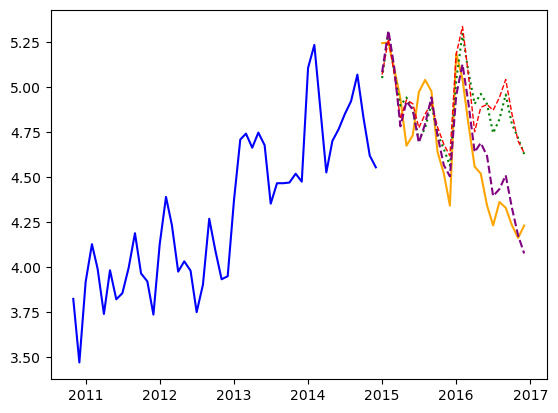

In [141]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.plot(df_train.index[-50:], df_train[-50:], c='blue')
plt.plot(df_val.index, df_val, c='orange')
plt.plot(df_val.index, forecasts, c='green', linestyle='dotted')
plt.plot(df_val.index, forecasts_2, c='red', linestyle='dashed', linewidth=1)
plt.plot(df_val.index, forecasts_tuned, c='purple', linestyle='dashed')

plt.show()